In [5]:
# Add the parent directory to sys.path

import sys
sys.path.append(os.path.abspath('..'))

import os
from torch.utils.data import Dataset
import numpy as np
from torch.utils.data import DataLoader

import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm

from CustomDatasets import SCAEDataset

In [6]:
train_dataset = SCAEDataset(root_dir="../data/train")
val_dataset = SCAEDataset(root_dir="../data/val")
test_dataset = SCAEDataset(root_dir="../data/test")


print(f"Dataset size: {len(train_dataset)}")

# Getting the first sample
image, label = train_dataset[0]
print(f"First image shape: {image.shape}, Label: {label}")


Dataset size: 22099
First image shape: torch.Size([1, 64, 64]), Label: 1


In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=4,shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=4,shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=4,shuffle=True, pin_memory=True)

In [8]:
### Define the SCAE as per the paper, although imo, it is very basic
class StackedConvAutoencoder(nn.Module):
    def __init__(self):
        super(StackedConvAutoencoder, self).__init__()
        
        # Encoder
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1)  # Output: 32x32
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # Output: 16x16
        
        # Decoder
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)  # Output: 16x16
        self.conv2 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1)  # Output: 32x32
        
        
    def forward(self, x):
        # Encoder
        x = F.relu(self.conv1(x))
        x, indices = self.pool(x)
        
        # Decoder
        x = self.unpool(x, indices)
        x = F.relu(self.conv2(x))
        return x


In [9]:
lr = 0.001

model = StackedConvAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

StackedConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (conv2): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)

In [10]:
num_epochs = 100  # Number of epochs to train for
best_val_loss = float('inf')

# Training loop
for epoch in tqdm(range(num_epochs)):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    for data in train_loader:
        inputs, _ = data
        inputs = inputs.to(device).float()
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}')

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        val_loss = 0.0
        for data in val_loader:
            inputs, _ = data
            inputs = inputs.to(device).float()
            
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            
            val_loss += loss.item()
        
        val_loss /= len(val_loader)
        print(f'Validation Loss: {val_loss:.4f}')
    
    # Check if the current validation loss is the best
    if val_loss < best_val_loss:
        print(f"Validation loss decreased ({best_val_loss:.4f} --> {val_loss:.4f}). Saving model...")
        best_val_loss = val_loss
        # Save model
        torch.save(model.state_dict(), '../models/SCAE_best.pth')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 191.1140
Validation Loss: 54.8846
Validation loss decreased (inf --> 54.8846). Saving model...
Epoch [2/100], Train Loss: 48.1634
Validation Loss: 43.6742
Validation loss decreased (54.8846 --> 43.6742). Saving model...
Epoch [3/100], Train Loss: 40.1661
Validation Loss: 37.5269
Validation loss decreased (43.6742 --> 37.5269). Saving model...
Epoch [4/100], Train Loss: 36.4023
Validation Loss: 35.2281
Validation loss decreased (37.5269 --> 35.2281). Saving model...
Epoch [5/100], Train Loss: 34.6944
Validation Loss: 34.1135
Validation loss decreased (35.2281 --> 34.1135). Saving model...
Epoch [6/100], Train Loss: 34.1510
Validation Loss: 34.1370
Epoch [7/100], Train Loss: 34.0406
Validation Loss: 33.9210
Validation loss decreased (34.1135 --> 33.9210). Saving model...
Epoch [8/100], Train Loss: 33.7331
Validation Loss: 33.3696
Validation loss decreased (33.9210 --> 33.3696). Saving model...
Epoch [9/100], Train Loss: 33.1381
Validation Loss: 32.6367
Validati

In [11]:
model.load_state_dict(torch.load('../models/SCAE_best.pth'))

<All keys matched successfully>

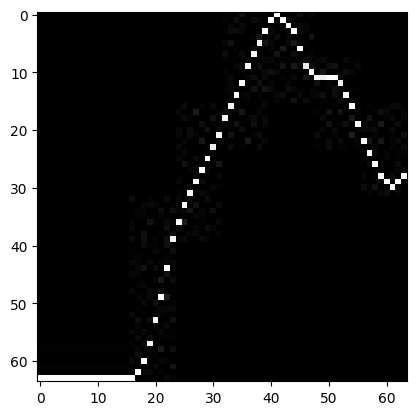

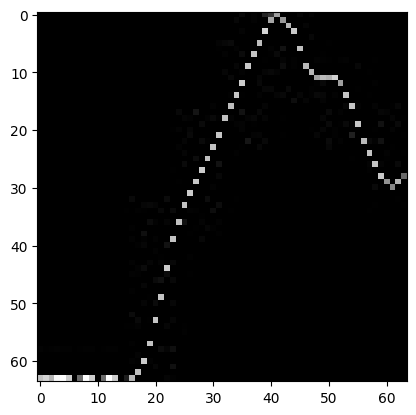

Artifact plot


In [17]:
import matplotlib.pyplot as plt

def plot_image(tensor):
    img = tensor.squeeze().cpu()
    img_np = img.numpy()

    # Display the image
    plt.imshow(img_np, cmap='gray')
    plt.show()


idx = 5
input_tensor = data[0][idx].float().to(device) # Example input
plot_image(input_tensor)

with torch.no_grad():
    output = model(input_tensor)
    plot_image(output)

print('Artifact plot') if data[1][idx]==1 else print('Non-Artifact plot')


torch.Size([1, 64, 64])